# ConvAbuse

Creating data files with texts and annotations from raw data.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../../../')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from datasets import load_dataset
from multitask_nlp.settings import DATASETS_DIR

tqdm.pandas()

dataset_path = DATASETS_DIR / 'convabuse'
abuse_values = [1, 0, -1, -2, -3]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_df(split: str, drop_incorrect_rows: bool):
    df = pd.read_csv(dataset_path / '2_splits'/ f'ConvAbuseEMNLP{split}.csv')
    
    df = df.astype({'example_id': 'int64'})  

    if drop_incorrect_rows:
        annot_columns = [f'Annotator{i+1}_is_abuse.{value}' for value in abuse_values for i in range(8)]
        index_to_drop = []
        for i, row in df.iterrows():
            for c in annot_columns:
                if row[c] not in ['0', '1', np.nan]:
                    index_to_drop.append(i)
                    break

        df = df.drop(index_to_drop).reset_index(drop=False)
        df = df.astype({c: 'float64' for c in annot_columns})
        
    return df

In [4]:
for split in ['train', 'valid', 'test']:
    df = load_df(split, drop_incorrect_rows=False)
    
    texts_df = df[['example_id', 'prev_agent', 'prev_user', 'agent', 'user']]
    texts_df = texts_df.rename(columns={'example_id': 'text_id'})
    texts_df = texts_df.drop_duplicates()

    major_voting_records = []

    for i, row in df.iterrows():
        text_id = row.example_id
        mv_is_abuse = row.is_abuse_majority
        major_voting_records.append({
            'text_id': text_id,
            'is_abuse': mv_is_abuse
        })
                        
    major_voting_df = pd.DataFrame.from_records(major_voting_records)

    texts_df.to_csv(dataset_path / f'text_data_{split}.csv', index=False)
    major_voting_df.to_csv(dataset_path / f'binary_abuse_mv_{split}.csv', index=False)
       

for split in ['train', 'valid', 'test']:
    df = load_df(split, drop_incorrect_rows=True)
       
    annotations_records = []

    for i, row in df.iterrows():
        text_id = row.example_id
        for i in range(8):
            annotator_id = i+1
            annotations = [row[f'Annotator{annotator_id}_is_abuse.{value}'] for value in abuse_values]    
            if all([not np.isnan(a) for a in annotations]):
                for value, annotation in zip(abuse_values, annotations):
                    if annotation == 1:
                        annotations_records.append({
                            'text_id': text_id,
                            'annotator_id': annotator_id,
                            'is_abuse': value
                        })
                        break
                        
    annotations_df = pd.DataFrame.from_records(annotations_records)
    annotations_df.to_csv(dataset_path / f'annotations_{split}.csv', index=False)
         

In [5]:
df_annot_mv = pd.concat([pd.read_csv(dataset_path / f'binary_abuse_mv_{split}.csv') for split in ['train', 'valid', 'test']])
df_annot_mv

,text_id,is_abuse
0,278,0
1,2626,0
2,1843,0
3,2102,0
4,2440,0
...,...,...
848,3420,0
849,2122,0
850,999,0
851,1223,0


In [6]:
df_annot_full = pd.concat([pd.read_csv(dataset_path / f'annotations_{split}.csv') for split in ['train', 'valid', 'test']])
df_annot_full

,text_id,annotator_id,is_abuse
0,278,2,1
1,278,3,1
2,278,7,1
3,2626,3,1
4,2626,7,1
...,...,...,...
1801,2122,4,1
1802,2122,6,-1
1803,2122,8,1
1804,1918,1,-1


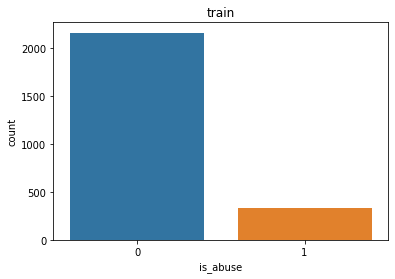

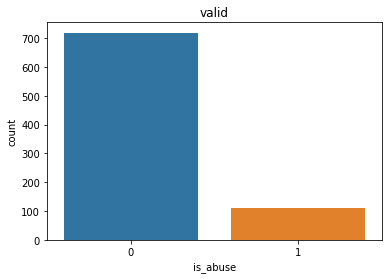

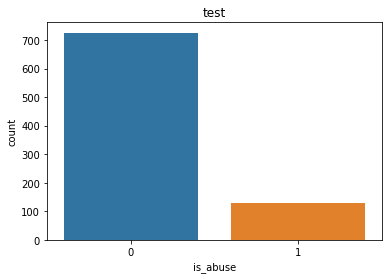

In [7]:
for split in ['train', 'valid', 'test']:
    fig, ax = plt.subplots()
    annot_df = pd.read_csv(dataset_path / f'binary_abuse_mv_{split}.csv')
    sns.countplot(x="is_abuse", data=annot_df, ax=ax)
    ax.set_title(split)

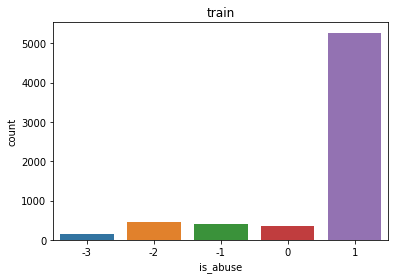

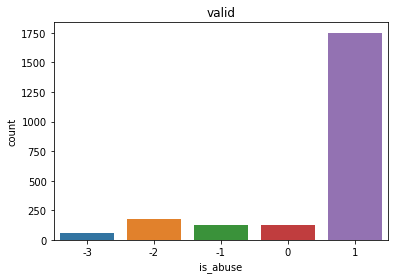

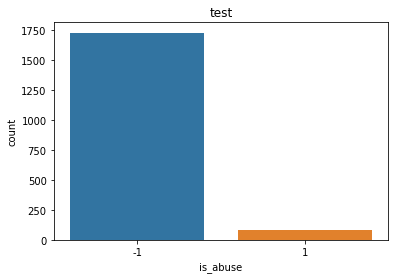

In [8]:
for split in ['train', 'valid', 'test']:
    fig, ax = plt.subplots()
    annot_df = pd.read_csv(dataset_path / f'annotations_{split}.csv')
    sns.countplot(x="is_abuse", data=annot_df, ax=ax)
    ax.set_title(split)